# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

# Installations and Setup

In [33]:
# Installations

!pip install datasets
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U

In [46]:
# Importations

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from datasets import load_metric
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

The "Weights & Biases" (wandb) platform will be disabled to avoid unnecessary interactions with external services.

In the context of machine learning and data science workflows, "Weights & Biases" is a platform that helps to track and visualize machine learning experiments. It provides tools for logging various metrics, visualizing training progress, and comparing different experiments.

The "Weights & Biases" (wandb) platform can also be disabled if using a different experiment tracking tool is preferred.

In [3]:
# Disabe W&B

os.environ["WANDB_DISABLED"] = "true"

# Data Exploration

In [4]:
# Load the dataset and display some values

df = pd.read_csv('data/Train.csv')
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [5]:
# Check the shape of the dataset

df.shape

(10001, 4)

In [6]:
# Check the datatype of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [7]:
# Check for missing values

df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

As can be seen, the label column has a row with missing value while the agreement column has two rows with missing values. Since there are few rows with missing values, the rows will be dropped.

In [22]:
# Eliminate rows containing missing values

df = df[~df.isna().any(axis=1)]

In [23]:
# Confirm that the rows with missing values have been eliminated

df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [9]:
# Check for duplicates

df.duplicated().sum()

0

There are no duplicates in the dataset.

# Data Visualization

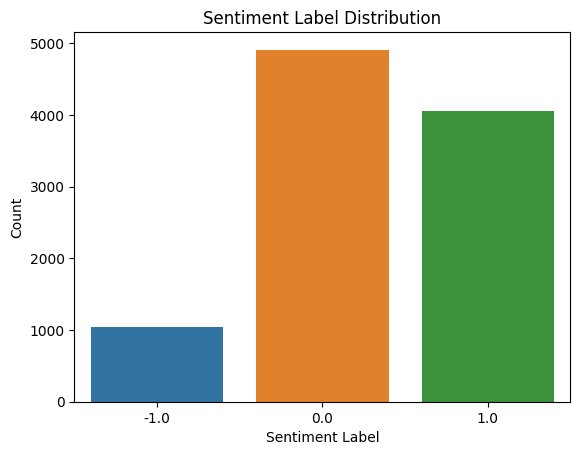

In [50]:
# Distribution of sentiment labels

sns.countplot(x="label", data=df)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

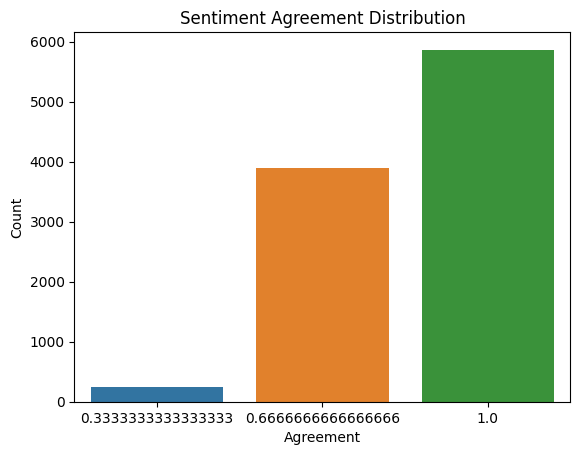

In [53]:
# Sentiment agreement distribution

sns.countplot(x="agreement", data=df)
plt.title("Sentiment Agreement Distribution")
plt.xlabel("Agreement")
plt.ylabel("Count")
plt.show()

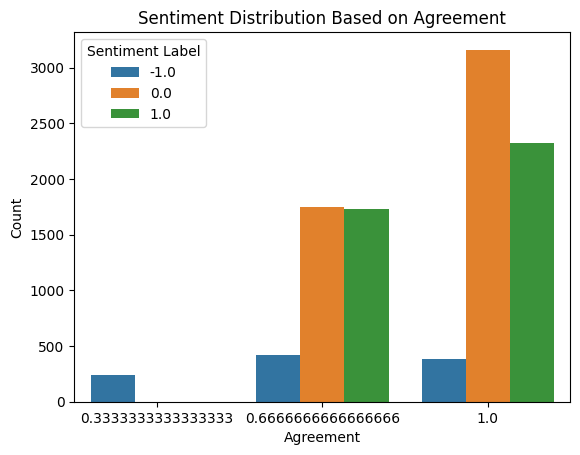

In [54]:
# Sentiment distribution based on agreement

sns.countplot(x="agreement", hue="label", data=df)
plt.title("Sentiment Distribution Based on Agreement")
plt.xlabel("Agreement")
plt.ylabel("Count")
plt.legend(title="Sentiment Label")
plt.show()

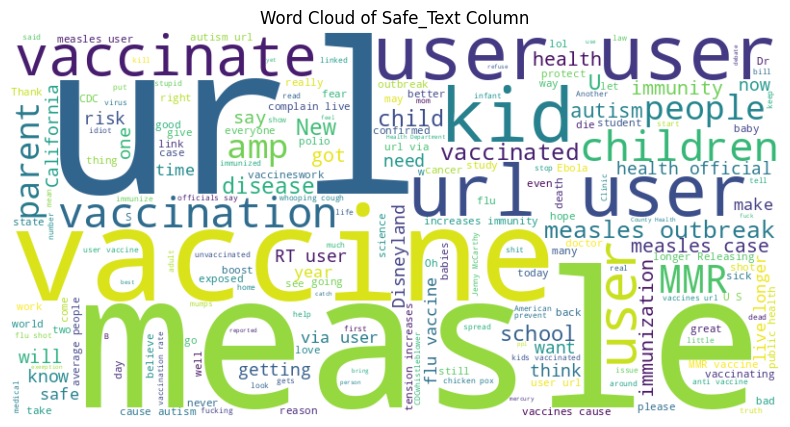

In [52]:
# Word cloud for "safe_text" column

text = " ".join(df["safe_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Safe_Text Column")
plt.axis("off")
plt.show()

# Data Transformation

### Splitting the dataset

I manually split the training set to have a training subset (a dataset the model will learn on), and an evaluation subset (a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [10]:
# Split the train data => {train, eval}

train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [11]:
# Display the first five rows of the train subset

train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.000000


In [12]:
# Display the first five rows of the evaluation subset

eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [13]:
# Display the shapes of the training and evaluation subsets

print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [14]:
# Save the splitted subsets

train.to_csv('data/train_subset.csv', index=False)
eval.to_csv('data/eval_subset.csv', index=False)

In [15]:
# Load the subsets into a dataset and encode the dataset using Latin-1 ("ISO-8859-1") encoding
# Latin-1 ("ISO-8859-1") encoding is used to read the text data in the dataset

dataset = load_dataset('csv',
                        data_files={'train': 'data/train_subset.csv',
                        'eval': 'data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

# Tokenization

Tokenization in Natural Language Processing (NLP) is the process of breaking down a sequence of text, such as a sentence or a paragraph, into individual units called tokens. Tokens are the fundamental building blocks used in text analysis, and they typically correspond to words or subwords.

Tokenization starts with a piece of text, which could be a sentence, a paragraph, or even an entire document.

The text is divided into smaller units known as tokens. These tokens can be words, subwords, or characters, depending on the granularity of the tokenization process.

Tokenization is a foundational step in many NLP tasks, including text classification, machine translation, sentiment analysis, and more. It transforms raw text data into a format that can be understood and processed by algorithms and models, facilitating various text analysis tasks.

In [16]:
# Create tokenizer object using AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [17]:
# Function to perform tokenization and padding
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Perform tokenization and padding on the tweets so that the models can be utilized
dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
# Function to transform the labels to fit the configuration of our pre-trained HuggingFace models
def transform_labels(label):
    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2
    return {'labels': num}

# Transform the	labels and remove unnecessary columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
# Display the dataset features

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [27]:
# Display the features of the train subset

dataset['train']

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 7999
})

# Model Loading

In [28]:
# Load BERT model

bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Fine-tuning

In [39]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    logging_dir="./logs",
)

# Trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['eval'],
)

# Train BERT model
bert_trainer.train()

ImportError: ignored

In [26]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset

training_args = TrainingArguments("test_trainer", num_train_epochs=1, load_best_model_at_end=True,)

ValueError: ignored

In [ ]:


# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

In [ ]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [ ]:


trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

In [ ]:
# Launch the learning process: training
trainer.train()

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [ ]:


metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation
trainer.evaluate()

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.